# Organized 3D Point Clouds

We demonstrate Polylidar3D being applied to an organized point cloud. Depth images from an Intel RealSense D435i will be processed. This example is taken from the much more thorough script titled `realsense_mesh.py`. Refer to that script for more details.

In [1]:
import time
import logging
import sys
import os
import json
from IPython.display import Image
SRC_DOCS = os.path.realpath(os.path.join(os.getcwd(), '..', '..', '..', 'src_docs', '_static' ))
sys.path.insert(0, '../../../')

In [51]:
import numpy as np
import open3d as o3d
from open3d import JVisualizer
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R

from examples.python.util.realsense_util import (get_realsense_data, get_frame_data, R_Standard_d400, prep_mesh,
                                                 create_open3d_pc, extract_mesh_planes, COLOR_PALETTE)

from polylidar import (Polylidar3D, MatrixDouble, MatrixFloat, extract_tri_mesh_from_float_depth,
                       extract_point_cloud_from_float_depth)

from polylidar.polylidarutil.open3d_util import construct_grid, create_lines, flatten, create_open_3d_mesh_from_tri_mesh
from polylidar.polylidarutil.plane_filtering import filter_planes_and_holes

from examples.python.realsense_mesh import run_test, callback


First we gather the data and visualize. The point cloud is colored by z-height,the blue points represent the floor of my basement.

In [41]:
color_files, depth_files, traj, intrinsics = get_realsense_data()
pcd, rgbd, extrinsics = get_frame_data(4, color_files, depth_files, traj, intrinsics, stride=2)
pcd = pcd.rotate(R_Standard_d400[:3, :3], center=False)
logging.info("File %r - Point Cloud; Size: %r", 4, np.asarray(pcd.points).shape[0])
o3d.visualization.draw_geometries([pcd])

INFO:root:File 4 - Point Cloud; Size: 24817


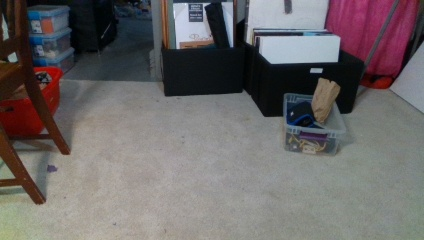

In [42]:
Image(f"{color_files[4]}")

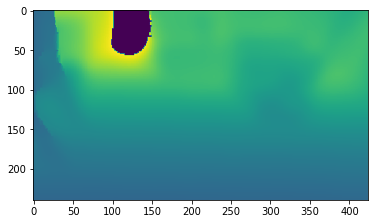

In [6]:
plt.imshow(np.asarray(rgbd.depth))

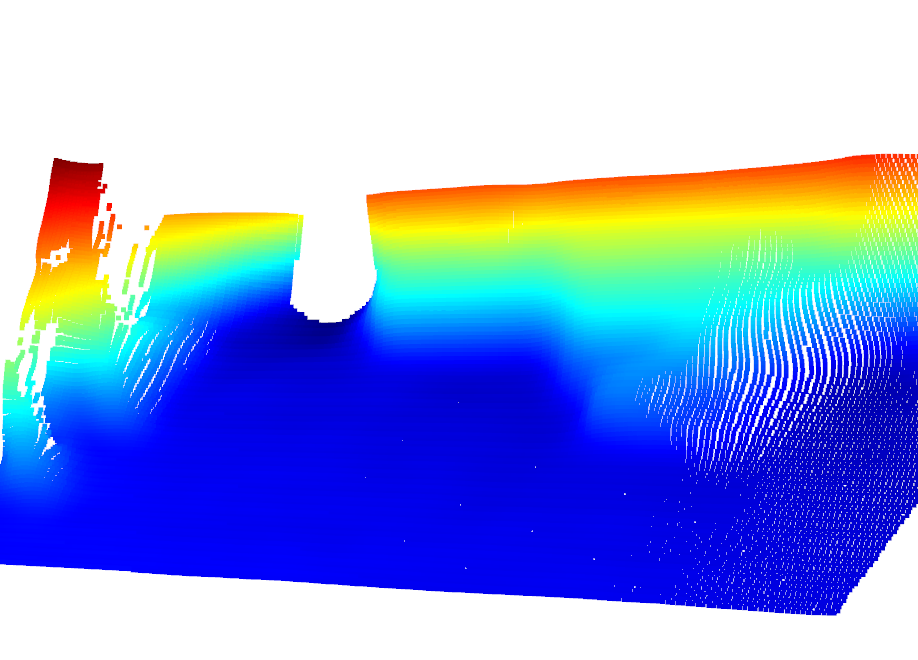

In [7]:
Image(f"{SRC_DOCS}/organized/organized_pc_raw.png")

In [43]:
run_test(pcd, rgbd, intrinsics, extrinsics, callback=callback, stride=2)

INFO:root:Treated as **Unorganized** Point Cloud - 2.5D Delaunay Triangulation with Polygon Extraction took 14.41 milliseconds
INFO:root:Treated as **Organized** Point Cloud - Right-Cut Triangulation/Uniform Mesh (Mesh only) took 1.71 milliseconds
INFO:root:Polygon Extraction on Uniform Mesh (only one dominant plane normal) took 2.77 milliseconds


This is the result of generating a Right-Cut Triangulaton/Uniform Mesh from the organized point cloud. It only took around a millisecond.

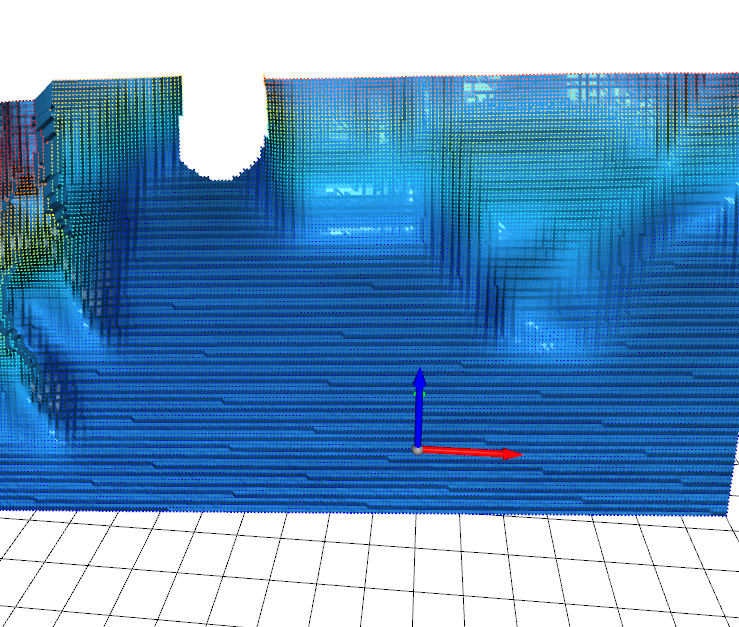

In [9]:
Image(f"{SRC_DOCS}/organized/organized_mesh.png")

Here is the result of using Polylidar3D to extract planar triangular segments and their polygonal representations which have similar orienation to the floor normal.
The basement floor is extracted as a polygon (green line). Notice that there were small holes in the mesh; these were filtered out with the parameter `min_hole_vertices`. Notice other planar segments were extracted (purple, red, orange, etc.). These can/were filtered out by either `min_triangles` or polygon post-processing with minimum area requirements.

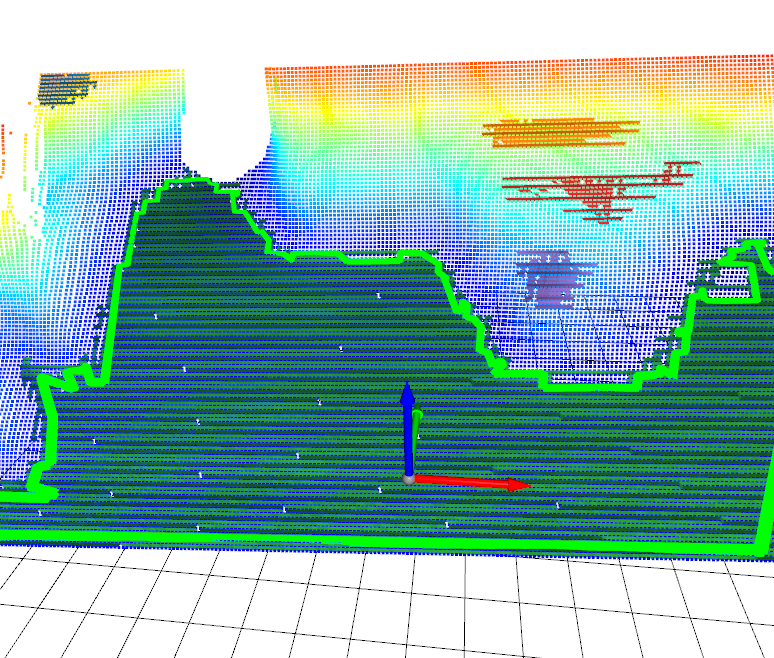

In [10]:
Image(f"{SRC_DOCS}/organized/organized_polygons.png")

See `realsense_mesh.py` to see how these images are exactly created. However the basics work like this

1. First create a half-edge triangular mesh of the depth image. Triangles are removed from invalid depth measurements (i.e.., 0).
2. Call Polylidar3D to extract Planes and Polygons from the mesh.
3. Filter polygons with polygon post-processing

Note that Polylidar3D can just take an organized point cloud *directly* if you have it: [extract_tri_mesh_from_organized_point_cloud](../../python_api/polylidar.extract_tri_mesh_from_organized_point_cloud.rst)

In [11]:
tri_mesh = extract_tri_mesh_from_float_depth(MatrixFloat(
    np.asarray(rgbd.depth)), MatrixDouble(np.ascontiguousarray(intrinsics.intrinsic_matrix)), MatrixDouble(extrinsics), stride=2)
num_triangles = np.asarray(tri_mesh.triangles).shape[0]

print(f"Number of triangles: {num_triangles}")

# Create Polylylidar3D object for extraction (you can keep using on more frames later if you desire)
polylidar_kwargs = dict(alpha=0.0, lmax=0.10, min_triangles=100,
                        z_thresh=0.04, norm_thresh=0.90, norm_thresh_min=0.90, min_hole_vertices=6)
pl = Polylidar3D(**polylidar_kwargs)

planes, polygons = pl.extract_planes_and_polygons(tri_mesh)
num_planes = len(planes)
print(f"Number of planar segments: {len(planes)}")
print(f"Number of polygons : {len(polygons)}")

points = np.asarray(tri_mesh.vertices)
config_pp = dict(filter=dict(hole_area=dict(min=0.025, max=100.0), hole_vertices=dict(min=6), plane_area=dict(min=0.5)),
                 positive_buffer=0.00, negative_buffer=0.02, simplify=0.01)

polygon_shells, polygons_holes = filter_planes_and_holes(polygons, points, config_pp)

print(f"Number of polygons after filtering: {len(polygon_shells)}")

Number of triangles: 48914
Number of planar segments: 5
Number of polygons : 5
Number of polygons after filtering: 1


# Extract Dominant Planes From Organized Point 

Here we will show another scene where multiple surfaces will be extracted that have different surface normals. Note that you **must** have [FastGA](https://github.com/JeremyBYU/FastGaussianAccumulator) installed as well as [OrganizedPointFilters](https://github.com/JeremyBYU/OrganizedPointFilters) for this example to work.

First lets look at some data I took from an L515 RealSense Sensor in my basement. We will load the depth image, our generated *organized* point cloud from the depth image, and any meta data we will need.

In [69]:
from examples.python.util.realsense_util import REALSENSE_DIR
from pprint import pprint
example_one = 'opc_example_one'
depth_image = np.load(os.path.join(REALSENSE_DIR, example_one, 'L515_Depth.npy'))
with open(os.path.join(REALSENSE_DIR, example_one, 'L515_meta.json')) as f:
    meta = json.load(f)

In [4]:
print("Depth Intriniscs: ")
pprint(meta['intrinsics'])

Depth Intriniscs: 
[[228.90548706054688, 0.0, 160.26693725585938],
 [0.0, 229.06289672851562, 94.28375244140625],
 [0.0, 0.0, 1.0]]


We can convert this depth image into an organized point cloud. This is with the following procedure:

In [71]:
intrinsics = np.array(meta['intrinsics'])
extrinsics = np.identity(4)
stride = 1
points = extract_point_cloud_from_float_depth(MatrixFloat(
    depth_image), MatrixDouble(intrinsics), MatrixDouble(extrinsics), stride=stride)
new_shape = (int(depth_image.shape[0] / stride), int(depth_image.shape[1] / stride), 3)
opc = np.asarray(points).reshape(new_shape)  # organized point cloud (will have NaNs!)
print(opc.shape)
print(opc[:3,:3,:3])
print("Note than any invalid depth measurments (e.g. 0) must be converted to nan values!")

(180, 320, 3)
[[[        nan         nan         nan]
  [        nan         nan         nan]
  [-0.87670461 -0.52191696  1.26800013]]

 [[        nan         nan         nan]
  [        nan         nan         nan]
  [-0.87929737 -0.5179085   1.27175009]]

 [[        nan         nan         nan]
  [        nan         nan         nan]
  [-0.880853   -0.51326298  1.27400005]]]
Note than any invalid depth measurments (e.g. 0) must be converted to nan values!


### Visualize the Raw Organized Point Cloud
Look at that beautiful L515 Sensor!

In [72]:
# pcd_np = np.array([[0,0,0], [1, 1, 1]])
pcd_np = opc.reshape((opc.shape[0] * opc.shape[1], 3))
pcd_np = pcd_np[~np.isnan(pcd_np).any(axis=1)] # cant have nans in o3d...boooo!!!
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcd_np))
o3d.visualization.draw_geometries([pcd])

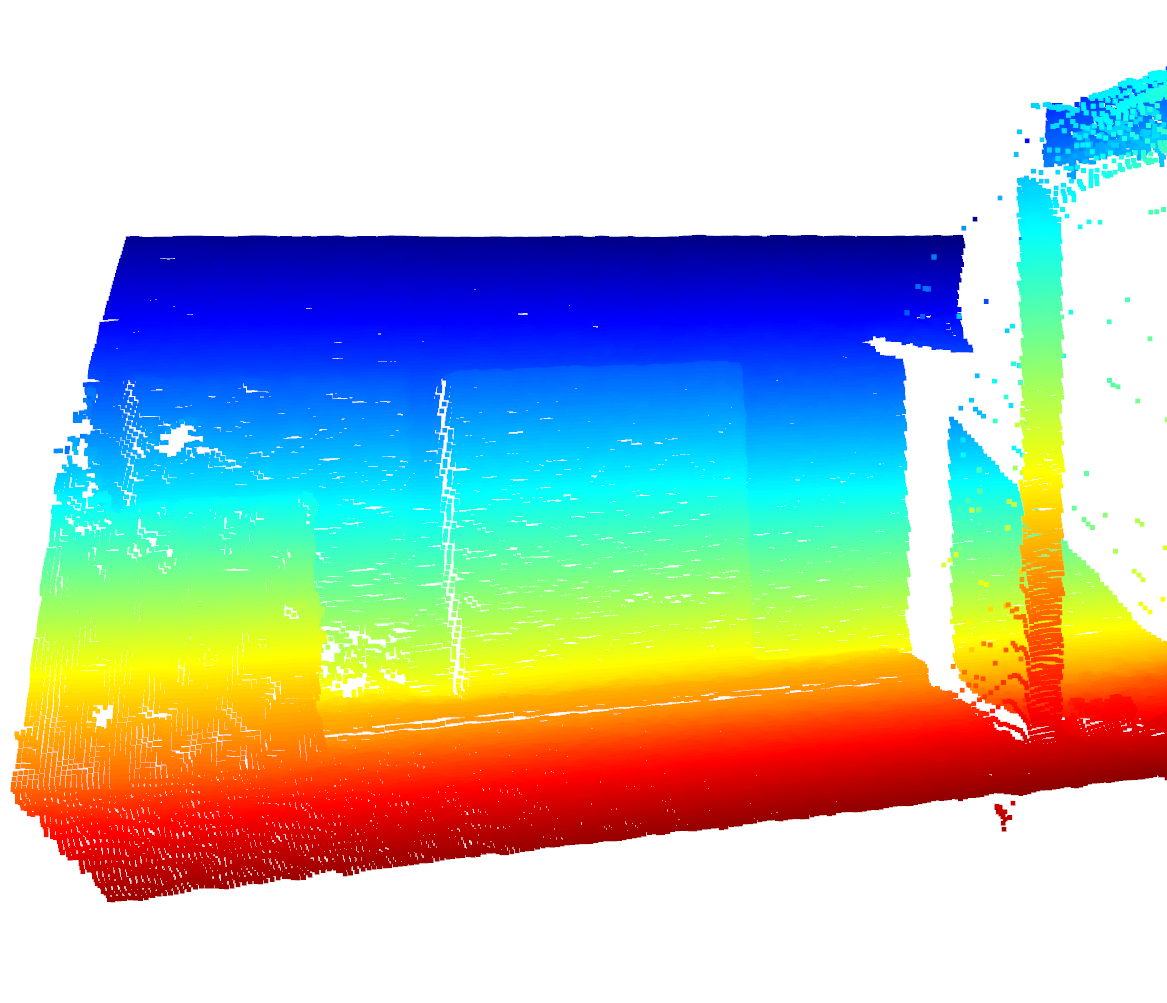

In [8]:
Image(f"{SRC_DOCS}/organized/l515_opc.png")

### Smooth Point Cloud and Create Mesh

First we need to smooth the point cloud and create a mesh. I have provided a helper module that uses `OrganizedPointFilters` to smooth the OPC. It used both Laplacian and Bilateral filtering. The mesh is then created using procedures in `Polylidar3D` itself.
Here are the parameters:

In [7]:
meta['mesh']

{'use_cuda': True,
 'stride': 1,
 'filter': {'loops_laplacian': 1,
  '_lambda': 1.0,
  'kernel_size': 3,
  'loops_bilateral': 3,
  'sigma_length': 0.2,
  'sigma_angle': 0.15}}

```
`use_cuda` - Use your GPU for smoothing to make procedures much faster
`loops_laplacian` - how many iterations of Laplacian smoothing
`_lambda` - Weight factor for laplacian smoothing. Leave at 1.0
`kernel_size` - The Laplacian kernel size. Can be 3 or 5. 3 will use get 8 neighbors, 5 will be 27 Neighbors. For very dense point cloud that are very noisy use 5.
`sigma_length` - bilater filtering parameter
`sigma_angle` -  bilateral filtering parameter
```

In [73]:
from examples.python.util.helper_mesh import create_meshes_cuda, create_meshes
use_cuda = True
if use_cuda:
    mesh, timings = create_meshes_cuda(opc, **meta['mesh']['filter'])
else:
    mesh, timings = create_meshes(opc, **meta['mesh']['filter'])

# Note that open3d can not have nan points in its vertices structure (since version 0.10.0), even if the vertices are not used in triangulation,
# must set them to 0 or some finite number, https://github.com/intel-isl/Open3D/issues/1188
mesh_o3d = create_open_3d_mesh_from_tri_mesh(mesh)
o3d.visualization.draw_geometries([mesh_o3d])

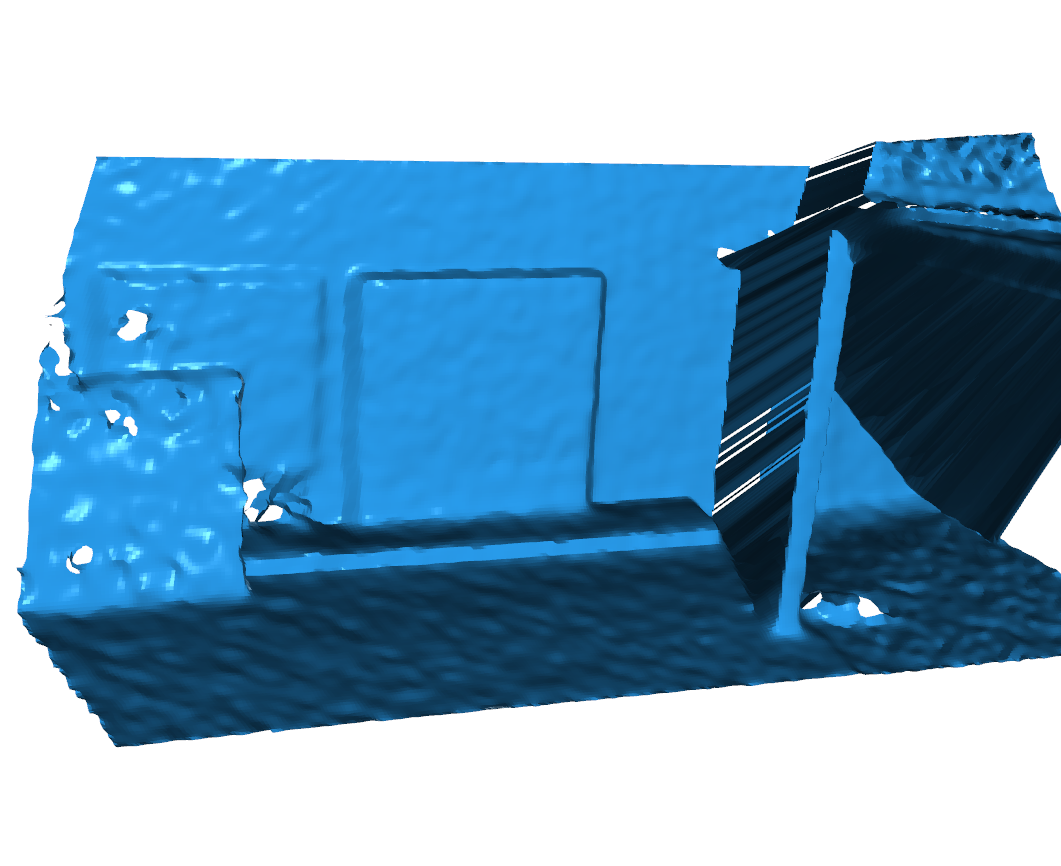

In [11]:
Image(f"{SRC_DOCS}/organized/l515_mesh_smooth.png")

### Identify Dominant Plane Normals

Now we will use FastGA to identify all the dominant planes. Here are some helper functions:

In [32]:
from fastga import GaussianAccumulatorS2, MatX3d, IcoCharts
from fastga.peak_and_cluster import find_peaks_from_ico_charts


def down_sample_normals(triangle_normals, down_sample_fraction=0.12, min_samples=10000, flip_normals=False, **kwargs):
    num_normals = triangle_normals.shape[0]
    to_sample = int(down_sample_fraction * num_normals)
    to_sample = max(min([num_normals, min_samples]), to_sample)
    ds_step = int(num_normals / to_sample)
    triangle_normals_ds = np.ascontiguousarray(triangle_normals[:num_normals:ds_step, :])
    if flip_normals:
        triangle_normals_ds = triangle_normals_ds * -1.0
    return triangle_normals_ds

def get_image_peaks(ico_chart, ga, level=2,
                    find_peaks_kwargs=dict(threshold_abs=2, min_distance=1, exclude_border=False, indices=False),
                    cluster_kwargs=dict(t=0.10, criterion='distance'),
                    average_filter=dict(min_total_weight=0.01),
                    **kwargs):

    normalized_bucket_counts_by_vertex = ga.get_normalized_bucket_counts_by_vertex(True)

    t1 = time.perf_counter()
    ico_chart.fill_image(normalized_bucket_counts_by_vertex)  # this takes microseconds
#     plt.imshow(np.asarray(ico_chart.image))
#     plt.show()
    peaks, clusters, avg_peaks, avg_weights = find_peaks_from_ico_charts(ico_chart, np.asarray(
        normalized_bucket_counts_by_vertex), find_peaks_kwargs, cluster_kwargs, average_filter)
    t2 = time.perf_counter()

    gaussian_normals_sorted = np.asarray(ico_chart.sphere_mesh.vertices)


    return avg_peaks

def extract_all_dominant_plane_normals(tri_mesh, level=5, ga_=None, ico_chart_=None, **kwargs):
    triangle_normals = np.asarray(tri_mesh.triangle_normals)
    triangle_normals_ds = down_sample_normals(triangle_normals, **kwargs)

    triangle_normals_ds_mat = MatX3d(triangle_normals_ds)

    ga.integrate(triangle_normals_ds_mat)

    avg_peaks = get_image_peaks(
        ico_chart, ga, level=level, **kwargs)

    ga.clear_count()
    return avg_peaks

Please see the FastGA Documentation to understand these parameters

In [17]:
meta['fastga']

{'level': 4,
 'down_sample_fraction': 0.12,
 'find_peaks_kwargs': {'threshold_abs': 50,
  'min_distance': 1,
  'exclude_border': True,
  'indices': False},
 'cluster_kwargs': {'t': 0.28, 'criterion': 'distance'},
 'average_filter': {'min_total_weight': 0.1}}

In [33]:
ga = GaussianAccumulatorS2(level=meta['fastga']['level'])
ico_chart = IcoCharts(level=meta['fastga']['level'])
avg_peaks = extract_all_dominant_plane_normals(
    mesh, ga_=ga, ico_chart_=ico_chart, **meta['fastga'])
print("The dominant plane surface normals in the sensor frame of refererence: ")
print(avg_peaks)

The dominant plane surface normals in the sensor frame of refererence: 
[[ 0.          0.52573111 -0.85065081]
 [ 0.         -0.85065081 -0.52573111]]


### Extract Planes and Polygons with Polylidar3D

Once again here is a heper function

In [66]:
def filter_and_create_open3d_polygons(points, polygons, rm=None):
    " Apply polygon filtering algorithm, return Open3D Mesh Lines "
    config_pp = dict(filter=dict(hole_area=dict(min=0.025, max=100.0), hole_vertices=dict(min=6), plane_area=dict(min=0.1)),
                     positive_buffer=0.00, negative_buffer=0.00, simplify=0.02)
    planes, obstacles = filter_planes_and_holes(polygons, points, config_pp, rm)
    all_poly_lines = create_lines(planes, obstacles, line_radius=0.01)
    return all_poly_lines


In [67]:
polylidar_kwargs=dict(alpha=0.0, lmax=0.05, min_triangles=500,
                      z_thresh=0.15, norm_thresh=0.95, norm_thresh_min=0.95, min_hole_vertices=10, task_threads=4)
pl = Polylidar3D(**polylidar_kwargs)

avg_peaks_mat = MatrixDouble(avg_peaks)
all_planes, all_polygons = pl.extract_planes_and_polygons_optimized(mesh, avg_peaks_mat)

vertices_np = np.asarray(mesh.vertices)
triangles_np = np.asarray(mesh.triangles)

mesh_3d_polylidar = []
for i in range(avg_peaks.shape[0]):
    avg_peak = avg_peaks[i, :]
    rm, _ = R.align_vectors([[0, 0, 1]], [avg_peak])
    all_poly_lines = filter_and_create_open3d_polygons(vertices_np, all_polygons[i], rm)
    mesh_3d_polylidar.extend(flatten([line_mesh.cylinder_segments for line_mesh in all_poly_lines]))

o3d.visualization.draw_geometries(
                [mesh_o3d, *mesh_3d_polylidar])

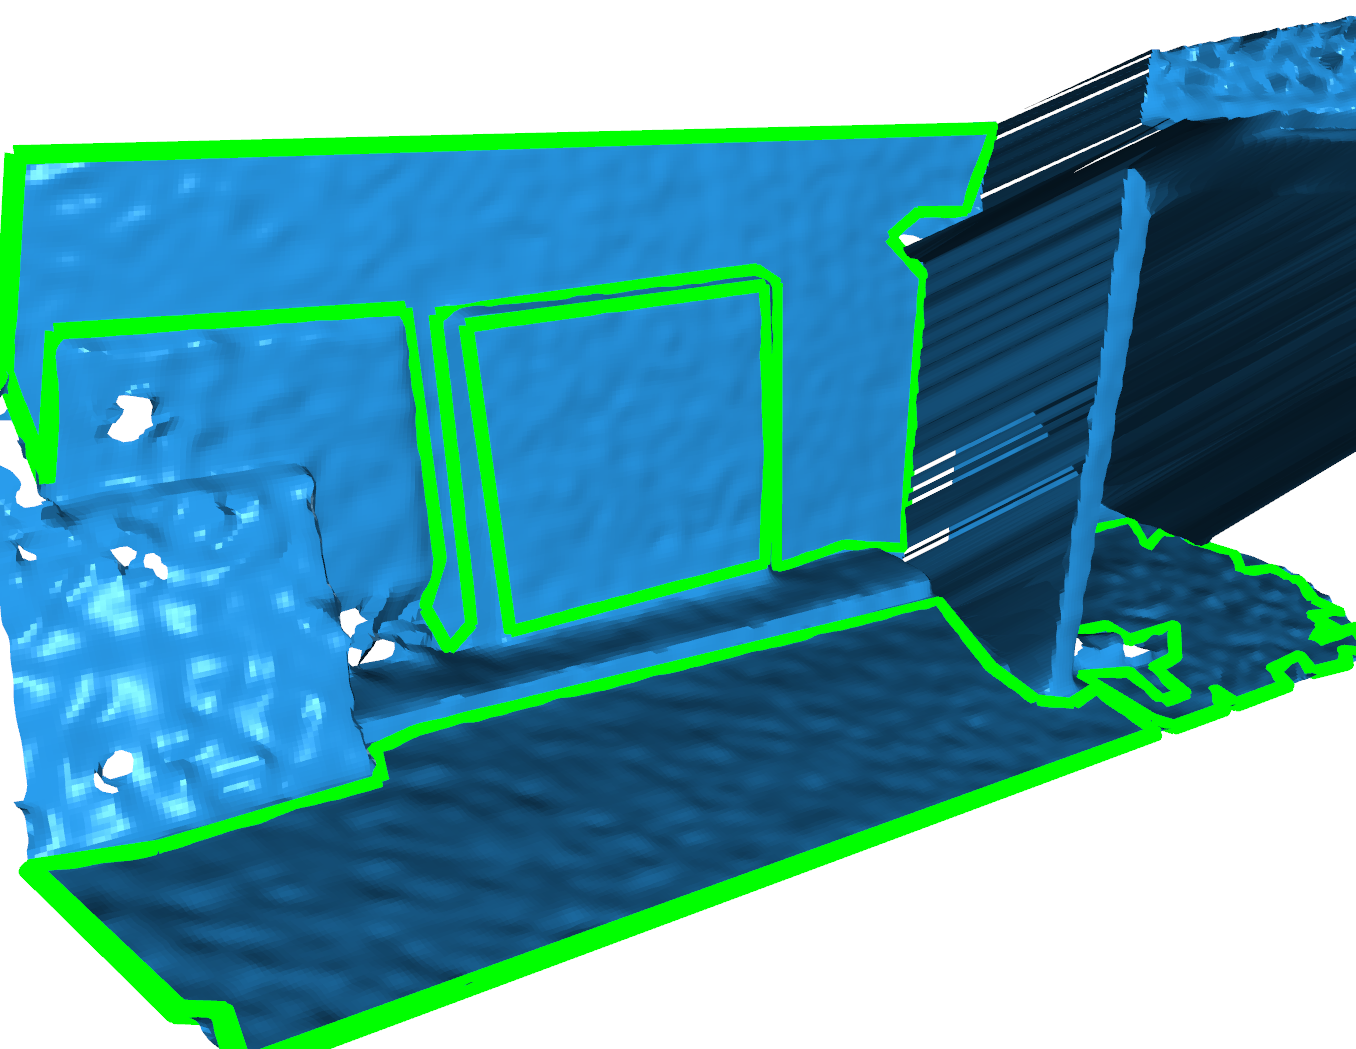

In [68]:
Image(f"{SRC_DOCS}/organized/l515_polygons.png")